# Lecture 4 -- Semantic Embeddings

## Outline

1. Problems with Ngrams
2. Semantic Embeddings
3. Semantic Similarity
4. UMAP and Clustering

The goal of this chapter is to demonstrate the power of semantic embeddings for search and clustering. At the end of this chapter you will know and apply both concepts to CDP transcript data.

## Problems with Ngram Counts

* Considering you need to store a count for every single unique ngram in the text this is a lot of unique items to store, even if you consider stemming, typo-correction, lowercases, etc. As the diversity of your corpus increases, the size of your dataset additionally grows to account for the diversity in word usage
* Any sort of models or plotting we build with ngram counts tend to not generalize to new data too well. there is always exceptions to the rule but think about how language and slang change over time or by geographic location. If we only created our dataset from Seattle discussion in 2019 and tried to apply some downstream model or analysis to Houston in 2023, we might have problems because there are new words we have never encountered, slang terms, etc.

* THAT SAID, we shouldn't discount ngrams fully. Ngrams are _specific_, if we are tracking an ngram, it means that ngram is guarenteed to have been in the corpus and we can find specific references to it

## Semantic Embeddings

* Instead of counting words or ngrams, the state-of-the-art is to create dense embeddings from text
* From this:

| text_id | hello | world | my | name | is | eva | ... |
| --------| ------| ------| ---| -----| ---| ----| ----|
| 0 | 1 | 1 | 1 | 1 | 1 | 1 | 0 |
| 1 | 1 | 0 | 1 | 1 | 1 | 0 | 1 |
| 2 | 0 | 0 | 0 | 0 | 3 | 0 | 2 |

* where each word is stored in its own column and each text example stores the counts of the words in each text example

* to this:

| text_id | dim_0 | dim_1 | dim_2 | dim_3 | ... |
| --------| ------| ------| ---| -----| ---|
| 0 | -0.2 | 0.4 | 0.7 | -0.1| -0.9 |
| 1 | -0.4 | 0.3 | 0.3 | -0.1 | -0.2 |
| 2 | 0.7 | -0.5 | -0.6 | 0.4 | 0.1 |

* we may not know what each these dimensions encode for, but we can learn them via machine learning

* this idea, of semantic embeddings, follows the basic idea that "you shall know a word by the company it keeps"
  * https://cmdowney88.github.io/teaching/uw_574/slides/3_WV_GD.pdf
  * https://calmcode.io/embeddings/introduction.html
* words (and sentences) that are used in similar contexts, are in some way related

* you can sort of think of it like this XKCD fruit plot:

![XKCD fruit plot with a "tastiness" axis (y) and a "difficulty of eating" axis (x). Various drawings of fruits scattered across the plot](https://imgs.xkcd.com/comics/fuck_grapefruit.png)

* in this case, we know the dimensions ("tastiness" and "difficulty of eating") but with semantic embeddings, we may not, we just know that each dimension encodes for a conceptual idea.

* the foundational paper for this idea was word2vec here:
  * If embeddings aren't familar to you, we recommend reading the following "illustrated version" of word2vec: https://jalammar.github.io/illustrated-word2vec/
 
* modern methods however have scaled this up a lot and its now very common to create semantic vectors for large portions of text

## Sentence Transformers

* fortunately for us, we don't have to train these models to do the encoding, others have doneso already

* and this is so common that there is good tooling for extracting these embeddings from text
* `SentenceTransformers` is specifically built to do so

* Let's give sentence transformers a quick try on some example text

In [1]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("all-distilroberta-v1")

# Get the semantic embedding for a piece of text
embedding_1 = model.encode("I want to thank UAW4121 for the help in crafting this legislation.")
embedding_1

array([ 2.50484832e-02, -1.92009285e-02, -4.78805862e-02,  6.51347160e-04,
        2.09571924e-02, -5.28855901e-03, -4.59072366e-02,  6.91789994e-03,
        3.56921926e-02, -3.05959675e-02, -4.23887298e-02, -3.55551578e-02,
       -5.04362620e-02, -7.47670755e-02,  2.30247714e-02, -6.62243962e-02,
        2.64527053e-02, -4.07546572e-03, -5.93089014e-02, -8.80574286e-02,
        2.73587238e-02, -7.05565438e-02,  1.83358975e-02,  5.94620453e-03,
        2.17716098e-02, -1.45498561e-02,  5.73872589e-02,  5.97409578e-03,
       -7.05154939e-03,  4.92351055e-02,  7.57808518e-03, -3.72921191e-02,
        1.92622747e-02,  1.67219378e-02, -8.19609407e-03,  1.22744981e-02,
        2.57517528e-02, -3.18145659e-03,  2.65956894e-02, -3.05894744e-02,
        2.17175893e-02, -6.55367086e-03,  1.22397235e-02,  6.47381321e-02,
       -4.17929562e-03, -1.11583276e-02, -2.03686692e-02, -6.04618676e-02,
       -1.84716769e-02,  3.04517746e-02, -1.44924838e-02,  1.44567210e-04,
        3.98083916e-03, -

* we can see that embeddings are vectors!

In [2]:
embedding_1.shape

(768,)

* we can't say for sure what each of these 768 dimensions encode for but we can hopefully show that these embedding vectors include enough information to show how similar two pieces of text are

* to do so, let's embed another piece of text that is similar to original one, but may have different words and a slightly different idea behind it.

In [3]:
embedding_2 = model.encode("I want to recognize the hard work put in by the Transit Riders Union in assisting in crafting this bill.")
embedding_2.shape

(768,)

In [4]:
from sentence_transformers.util import cos_sim

cos_sim(embedding_1, embedding_2).item()

0.6145123243331909

* This number may not make a lot of sense right now so for comparison, let's try to write a sentence that is very different from the other two and see how similar it is to the other via the embedding

In [5]:
embedding_3 = model.encode("The council is terrible and should be ashamed.")

# Compare sentence 1 and 3 and compare sentence 2 and 3
cos_sim(embedding_1, embedding_3).item(), cos_sim(embedding_2, embedding_3).item()

(0.1019233763217926, 0.15606224536895752)

* when we look at the similarity between embedding 1 or embedding 2 and embedding 3, we notice the "similarity" is much lower.

* the sentences we wrote that we intended to be similar had a cosine similarity of 0.615. And when comparing the sentence that we wrote to try to be different from the other two both were less than 0.156.

* if I was to label the first two examples I might say that the first two were about "thankfullness", "recognition", "legislation", "assistance", etc. the third example was really just "angry"

* And this makes sense, cosine similarity is a metric calcuated between two vectors and results in a value between 0 and 1, with 0 being the exact opposite and 1 being the exact same.

## Semantic Search

* we can use this calculatable similarity metric to search through a collection of documents

* while "keyword search" using ngrams is specific, semantic search relies on the similarity of your query and each document in the corpus

* for example, lets create a fake corpus from possible statements from a council meeting

In [6]:
import pandas as pd

corpus = pd.DataFrame({"text": [
    "Hello my name is Eva and I support this bill",
    "Hello my name is Eva and I do not support this bill",
    "We are not accepting public comments at this time",
    "Welcome to the meeting of the Seattle City Council Transportation Committee",
    "We will have a presentation later on from the Seattle Department of Transportation",
    "I am sorry, could you please explain that slide again",
]})
corpus

,text
0,Hello my name is Eva and I support this bill
1,Hello my name is Eva and I do not support this...
2,We are not accepting public comments at this time
3,Welcome to the meeting of the Seattle City Cou...
4,We will have a presentation later on from the ...
5,"I am sorry, could you please explain that slid..."


* next we can encode all of the sentences to get embeddings

In [7]:
corpus["embedding"] = list(model.encode(corpus.text))
corpus

,text,embedding
0,Hello my name is Eva and I support this bill,"[0.03396301, 0.04418882, -0.03652103, 0.000163..."
1,Hello my name is Eva and I do not support this...,"[0.030697862, 0.05065392, -0.034959856, -0.014..."
2,We are not accepting public comments at this time,"[0.010806136, -0.025713393, -0.00017451386, 0...."
3,Welcome to the meeting of the Seattle City Cou...,"[0.036297053, -0.010011774, -0.034358032, -0.0..."
4,We will have a presentation later on from the ...,"[0.00076063693, -0.016124507, -0.017413434, -0..."
5,"I am sorry, could you please explain that slid...","[-0.03183143, -0.04133318, 0.023597926, 0.0109..."


* Now lets trying querying for a broad concept like "transporation presentation"
* even though none of the sentences contain the specific phrase "transporation presentation", if everything is to work, we expect the top two most similar to be sentences 4 and 3 in that order because sentence four mentions a presentation and department of transportation, while 3 mentions transporation committee

In [8]:
query_embedding = model.encode("transportation presentation")

corpus["similarity"] = corpus.embedding.apply(lambda stored_embed: cos_sim(query_embedding, stored_embed).item())
corpus.sort_values(by="similarity", ascending=False)

,text,embedding,similarity
4,We will have a presentation later on from the ...,"[0.00076063693, -0.016124507, -0.017413434, -0...",0.575698
3,Welcome to the meeting of the Seattle City Cou...,"[0.036297053, -0.010011774, -0.034358032, -0.0...",0.425648
5,"I am sorry, could you please explain that slid...","[-0.03183143, -0.04133318, 0.023597926, 0.0109...",0.272697
0,Hello my name is Eva and I support this bill,"[0.03396301, 0.04418882, -0.03652103, 0.000163...",0.086764
1,Hello my name is Eva and I do not support this...,"[0.030697862, 0.05065392, -0.034959856, -0.014...",0.071163
2,We are not accepting public comments at this time,"[0.010806136, -0.025713393, -0.00017451386, 0....",0.070965


* great! 4 and 3 were the top 2 examples, and sentence 5 was next, presumably because it talks about "slides" which are common in presentations.

* keyword matches are great and are needed for specificity but semantic embeddings and cosine similarity enable generalized search even when the specific query isn't present in the text!

## Semantic Neighborhoods

* we can also think about visualizing "semantically similar" clusters of documents using these embeddings
* The problem is that we have so many dimensions...
* Remember the XKCD plot of fruits? we can try to do something similar with two dimensions at a time

In [9]:
frames = []
for i, embedding_dim in enumerate(model.encode(corpus.text).T):
    frames.append(pd.Series(embedding_dim, name=f"embedding_dim_{i}"))

corpus = pd.concat([corpus, *frames], axis=1)

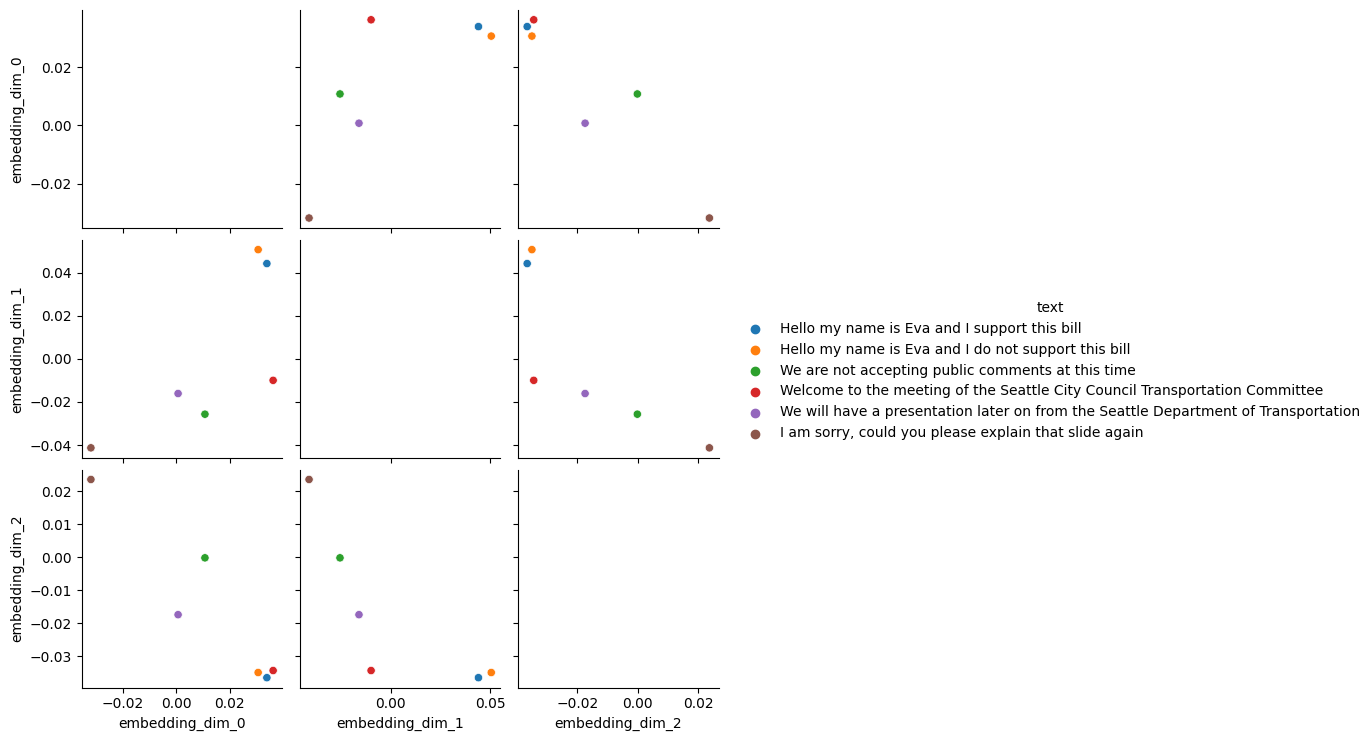

In [10]:
import seaborn as sns

sns.pairplot(data=corpus[["text", "embedding_dim_0", "embedding_dim_1", "embedding_dim_2"]], hue="text")

* Lets try to understand some of these plots.
* When comparing dimension 1 and dimension 0 (the top-row, middle) plot, we see that the two "Hello my name is Eva ..." comments are close together, and the "We are not accepting public comment..." and "We will have a presentation..." comments are near each other but not too close. The other two are relatively far from other points.
  * How might we interpret this?
  * We don't have names for the dimensions so it's hard
  * the two introductions ("hi my name is eva...") next to each other make sense. and you might be able to argue that "public comment" is _similar_ to a presentation. but it's hard to fully understand what each of these dimensions mean.


* Similarly lets look at dimension 0 and dimension 2 (bottom-row, left) plot, the "hello my name is eva" and the "welcome to the meeting..." are all close together and everything else is relatively scattered.
  * Again, how do we interpret this?
  * In this case, you might argue that "hello my name is..." and "welcome to the meeting..." are all "introductions or greeting" type statements and that is why they are clustered together.

* the point is, it's hard.

* With 768 dimensions we very quickly start to lose track of what each dimension may encode
* fortunately there are tools that try to downsample all 768 of these dimensions down to 2 specifically for plotting purposes

## UMAP

* UMAP is an algorithm specifically designed to reduce the dimensions of an embedding space
* In our case, we want to use UMAP to go from 768 dimensions to just 2!
* For a deep dive into how UMAP works, see: https://pair-code.github.io/understanding-umap/

* Let's try using UMAP on our small example set

/home/eva/miniforge-pypy3/envs/ml-for-pit/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eva/miniforge-pypy3/envs/ml-for-pit/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eva/miniforge-pypy3/envs/ml-for-pit/lib/python3.10

<Axes: >

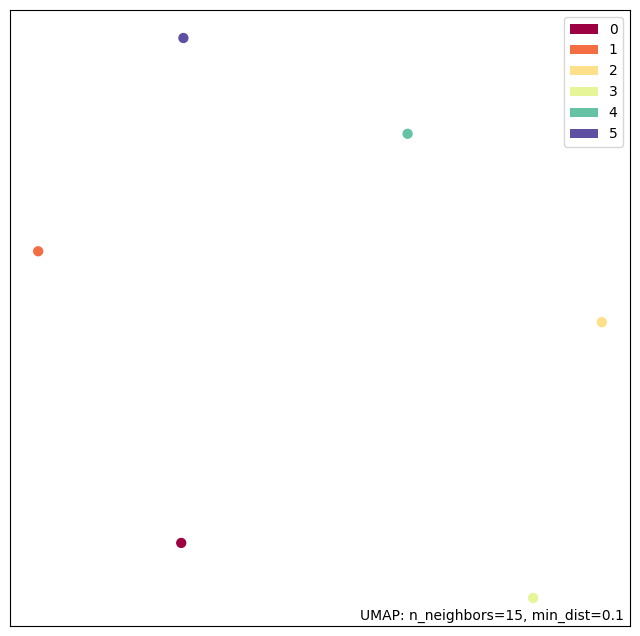

In [11]:
from umap import UMAP
import umap.plot
import numpy as np

mapper = UMAP().fit(np.stack(corpus["embedding"]))
umap.plot.points(mapper, labels=np.arange(len(corpus)))

* every single point is distant from the others
* And that is the _idea_, none of the pieces of text are really that similar
  * yes we have two texts that start the same "hi my name is eva" but their purpose is different, support or do not support a hypothetical piece of legislation
* We want to be able to separate points by downsampling all of their dimensions to just two.
* we aren't selecting two of the dimensions, we are sort of merging all of the dimensions together

* NOTE: there are always going to be some problems.
  * anyway you do it, converting 768 dimensions down to just 2, means you are losing information

## Using UMAP for Clustering

* Finally, let's try using UMAP on a single meetings transcript sentences so we can test it out with more data
* Additionally, lets take this opportunity to work through how to use UMAP to preprocess your embeddings to then be clustered

* We are going to follow along with UMAP's own documentation: https://umap-learn.readthedocs.io/en/latest/clustering.html#umap-enhanced-clustering

* first let's get a single meeting's data
  * we will use this meeting as an example: http://councildataproject.org/seattle/#/events/ddcce1484e43 

In [12]:
from cdp_data import datasets, CDPInstances
from cdp_backend.pipeline.transcript_model import Transcript

sessions = datasets.get_session_dataset(
    CDPInstances.Seattle,
    start_datetime="2022-03-15",
    end_datetime="2022-03-16",
    store_transcript=True,
)
session = sessions.iloc[0]
with open(session.transcript_path) as open_t:
    transcript = Transcript.from_json(open_t.read())

Fetching each model attached to event_ref:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/2 [00:00<?, ?it/s]

* now, lets create text snippets of three sentences in length
  * this is arbitrary, we are just trying to get more text in a single example

In [13]:
transpo_meeting_corpus = []

# Go from 0 to end with 3 sentence steps
step_size = 3
for sent_index in range(0, len(transcript.sentences), step_size):
    sentence_block = transcript.sentences[sent_index: sent_index + step_size]
    transpo_meeting_corpus.append(" ".join([s.text for s in sentence_block]))

# Store to dataframe and get embeddings
transpo_meeting_corpus = pd.DataFrame({"text": transpo_meeting_corpus})
transpo_meeting_corpus["embedding"] = list(model.encode(transpo_meeting_corpus.text))
transpo_meeting_corpus.sample(3)

,text,embedding
293,We'll be identifying new program and project n...,"[0.019899262, -0.017861, 0.012053543, 0.014548..."
163,"There's one off of University, which you can s...","[0.011485627, -0.046493206, 0.02532122, 0.0192..."
378,"And so in this plan, it is important that we'r...","[0.027091825, 0.0048495214, 0.004482967, 0.058..."


* Now that we have 3 sentence snippets of text and all of them have been given an embedding, let's cluster!
* Due to how UMAP works, by preprocessing the embeddings down to just 2 dimensions, and trying to separate examples from each other, its produces 2 dimensional space can be useful for clustering

In [14]:
import hdbscan
import matplotlib.pyplot as plt
%matplotlib inline

# Use UMAP to preprocess our embeddings to help us cluster later
clusterable_embedding = UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(np.stack(transpo_meeting_corpus["embedding"]))

# Actually perform the clustering
labels = hdbscan.HDBSCAN(
    # number of snippets in a neighborhood for a point to be considered a core point
    # higher is "more conservative clustering"
    min_samples=2,
    # minimum number of snippets needed to form a cluster
    # higher is "more conservative clustering"
    min_cluster_size=12,
).fit_predict(clusterable_embedding)
transpo_meeting_corpus["label"] = labels

<Axes: xlabel='plotting_x', ylabel='plotting_y'>

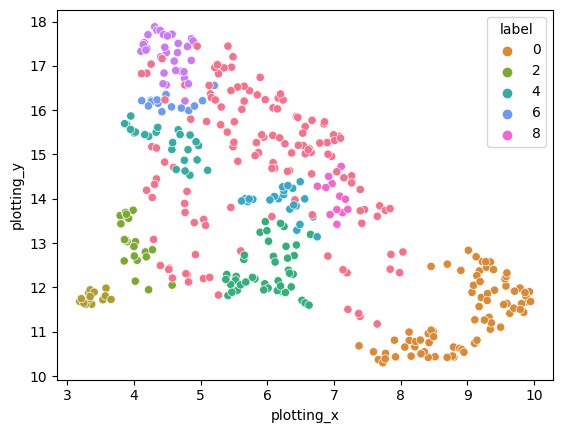

In [15]:
# Join everything together to get plotting ready dataframe
plotting_embedding = UMAP(random_state=42).fit_transform(np.stack(transpo_meeting_corpus["embedding"]))
transpo_meeting_corpus["plotting_x"] = plotting_embedding[:,0]
transpo_meeting_corpus["plotting_y"] = plotting_embedding[:,1]

sns.scatterplot(data=transpo_meeting_corpus, x="plotting_x", y="plotting_y", hue="label", palette="husl")

* it does _look_ like there are clusters, but it's hard to tell
* we can examine these clusters by grouping by the cluster id and trying to assign a text label ourselves

In [16]:
# Iter over clusters and print snippets and keywords
for group_value, group_df in transpo_meeting_corpus.groupby("label"):
    if group_value == -1:
        continue
    
    print(f"Cluster: {group_value}")
    for snippet in group_df["text"].sample(5):
        print(f"'{snippet}'")
        print()
    
    print()
    print("-" * 40)

Cluster: 0
'When you actually add those up, the pluses and minuses, we've actually provided 222 more square feet of open space than originally in the package that was approved way back when. We've also provided 52 extra seats in the open space. We do have one less tree.'

'Yeah, so that's, it's specified in the ordinance, and so that would be sort of the enforcement. So if it wasn't happening, we could go back to the permit holder and say, you know, you're not doing this, and it's a term of the condition of the ordinance. I was going to turn it over to Deitra, and so that she can talk about how they anticipate managing the site and the events long-term.'

'And that would allow for the transfer of the property ownership of the alley right of way to the building's owner. And if you don't have any questions on that framework for decision making, I'll hand it over to the rest of the presenters who will talk about the project itself. Thank you.'

'We do have the bike dock, the seating. We h

* Let's try to give names to these clusters
* Cluster 0: "discussion on permits and regulations for public and bike infrastructure"
* Cluster 1: "adminstrative management of public comments"
* Cluster 2: "public commenter introductions"
* Cluster 3: "councilmembers and staff meeting administration"
* Cluster 4: "discussion on transit and light rail"
* Cluster 5: "discussion on how to communicate and get feedback from the public"
* Cluster 6: "disucssion on bike infrastructure planning"
* Cluster 7: "public comments on climate and bike planning"
* Cluster 8: "description on how presentation availability and outline"
* Cluster 9: "vision and offline planning"

* For now, lets create a final plot using our new cluster names

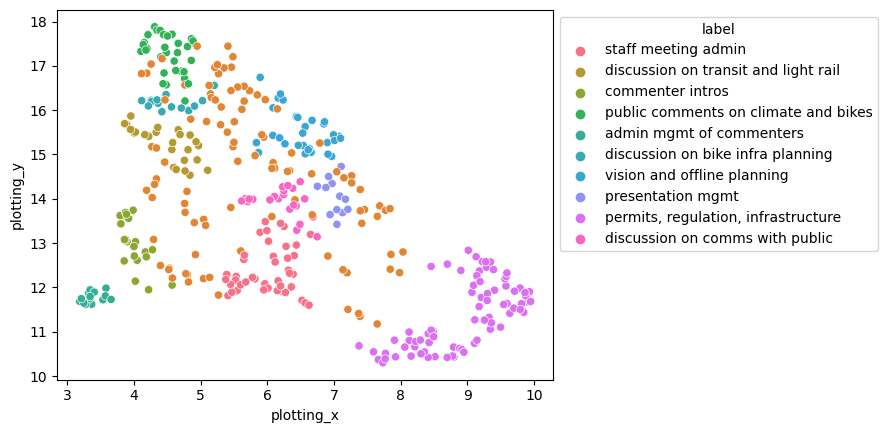

In [17]:
transpo_meeting_corpus["label"] = transpo_meeting_corpus.label.replace({
    -1: "_no cluster",
    0: "permits, regulation, infrastructure",
    1: "admin mgmt of commenters",
    2: "commenter intros",
    3: "staff meeting admin",
    4: "discussion on transit and light rail",
    5: "discussion on comms with public",
    6: "discussion on bike infra planning",
    7: "public comments on climate and bikes",
    8: "presentation mgmt",
    9: "vision and offline planning",
})

ax = sns.scatterplot(data=transpo_meeting_corpus, x="plotting_x", y="plotting_y", hue="label", palette="husl")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

* This seems potentially more clear
* there are a nice tightly packed group of text snippets which are the cluster of "admin management of public commenters"
* the "admin management of public commenters" is near the "public commenters introducing themselves" cluster
* there is a cluster which seems a bit separate and large which is about "permits, regulation, and infrastructure" that is separate from everything else, which sort of makes sense as it seems more nitty gritty detail oriented

* NOTE: none of these are perfect, clustering can be very subjective and you may have come up with different words to describe each of these
* Additionally, changing the parameters of the clustering algorithm can drastically affect this
